# Bounding boxes

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

from PIL import Image

### Read in data

In [3]:
# get all file names
path = 'generator'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)
n

1000

Decipher label legend

In [4]:
a = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[1])
b = np.zeros(3)
b[:] = a[1],a[2],a[3]
b

array([17., 24., 17.])

In [11]:
y = np.zeros(shape=(n,3),dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    yy = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[i])
    y[i,:] = yy[1],yy[2],yy[3]
    X[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

# add width (which is equal to the height)
y = np.hstack((y,y[:,2].reshape(-1,1)))

In [23]:
def center_hw_to_square(y):
    x,y,h,w = y
    x1 = x-w
    x2 = x+w
    y1 = y-h
    y2 = y+h
    return [x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1]

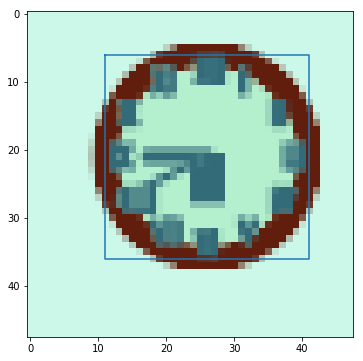

In [31]:
# sample input and label
fig, ax = plt.subplots(ncols=1,figsize=(16,6))
i = np.random.randint(0,n)
ax.imshow(X[i])
ax.plot(*center_hw_to_square(y[i]))
plt.show()

### Generate model

In [34]:
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten

In [35]:
input_layer = Input(shape=(X.shape[1:]))
conv1 = Convolution2D(16, kernel_size=3, padding='same',activation='relu')(input_layer)
pool1 = MaxPooling2D()(conv1)

conv2 = Convolution2D(32, kernel_size=3, padding='same',activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)

conv3 = Convolution2D(64, kernel_size=3, padding='same',activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)

dense = Dense(256,activation='relu')(Flatten()(pool3))

output = Dense(4)(dense)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
__________

### Train model

In [36]:
model.fit(X,y,epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 92.1198 - mean_absolute_error: 7.1539
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 12.7979 - mean_absolute_error: 2.8525
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 11.4967 - mean_absolute_error: 2.6878: 0s - loss: 11.5270 - mean_absolute_error
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 10.5309 - mean_absolute_error: 2.5578
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 8.3525 - mean_absolute_error: 2.2570
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 4.4272 - mean_absolute_error: 1.6522
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.3969 - mean_absolute_error: 1.4345
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.1947 - mean_absolute_error: 1.3981
Ep

### Read in test-set and evaluate

In [40]:
path = 'test'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3

y_t = np.zeros(shape=(n,3),dtype=int)
X_t = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    yy = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[i])
    y_t[i,:] = yy[1],yy[2],yy[3]
    X_t[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

y_t = np.hstack((y_t,y_t[:,2].reshape(-1,1)))   

In [41]:
model.evaluate(X_t,y_t)

1000/1000 [==============================] - 1s 706us/step


[2.5943880062103273, 1.270148458480835]

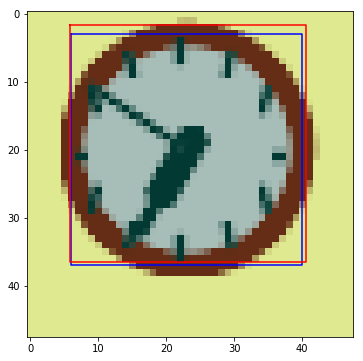

In [54]:
fig, ax = plt.subplots(ncols=1,figsize=(16,6))
i = np.random.randint(0,n)
ax.imshow(X_t[i])
pred = model.predict(X_t[i:i+1])[0]
# ground truth
ax.plot(*center_hw_to_square(y_t[i]),c='blue')
# predicted
ax.plot(*center_hw_to_square(pred),c='red')

plt.show()